In [1]:
import numpy as np
import pandas as pd
# import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [61]:
%pip install mlflow dagshub -q
%pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.3 MB/s eta 0:00:00


In [4]:
import dagshub
dagshub.init(repo_owner='AbdurRahman22224', repo_name='swiggy-del-time-predn', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=11daadaa-ad33-4863-8eb9-716fd9416669&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=18683080148e5253562f4bf17f398e33506c91e5ab0f6c04bde9c703e03cc120




Accessing as AbdurRahman22224

Initialized MLflow to track repo "AbdurRahman22224/swiggy-del-time-predn"

Repository AbdurRahman22224/swiggy-del-time-predn initialized!

In [10]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow")


In [11]:
mlflow.set_experiment("Exp 1 - Model Selection")

2025/06/07 14:15:11 INFO mlflow.tracking.fluent: Experiment with name 'Exp 1 - Model Selection' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/5f935ff1b2054f70832ffcd842d8bbca', creation_time=1749305711885, experiment_id='0', last_update_time=1749305711885, lifecycle_stage='active', name='Exp 1 - Model Selection', tags={}>

In [12]:
from sklearn import set_config
set_config(transform_output="pandas")

### Data Cleaning

In [13]:
df = pd.read_csv('swiggy.csv')
import numpy as np
import pandas as pd


def change_column_names(data: pd.DataFrame):
    return (
        data.rename(str.lower,axis=1)
        .rename({
            "delivery_person_id" : "rider_id",
            "delivery_person_age": "age",
            "delivery_person_ratings": "ratings",
            "delivery_location_latitude": "delivery_latitude",
            "delivery_location_longitude": "delivery_longitude",
            "time_orderd": "order_time",
            "time_order_picked": "order_picked_time",
            "weatherconditions": "weather",
            "road_traffic_density": "traffic",
            "city": "city_type",
            "time_taken(min)": "time_taken"},axis=1)
    )


def data_cleaning(data: pd.DataFrame):
    minors_data = data.loc[data['age'].astype('float') < 18]
    minor_index = minors_data.index.tolist()
    six_star_data = data.loc[data['ratings'] == "6"]
    six_star_index = six_star_data.index.tolist()

    return (
        data
        .drop(columns="id")
        .drop(index=minor_index)                                                # Minor riders in data dropped
        .drop(index=six_star_index)                                             # six star rated drivers dropped
        .replace("NaN ",np.nan)                                                 # missing values in the data
        .assign(
            # city column out of rider id
            city_name = lambda x: x['rider_id'].str.split("RES").str.get(0),
            # convert age to float
            age = lambda x: x['age'].astype(float),
            # convert ratings to float
            ratings = lambda x: x['ratings'].astype(float),
            # absolute values for location based columns
            restaurant_latitude = lambda x: x['restaurant_latitude'].abs(),
            restaurant_longitude = lambda x: x['restaurant_longitude'].abs(),
            delivery_latitude = lambda x: x['delivery_latitude'].abs(),
            delivery_longitude = lambda x: x['delivery_longitude'].abs(),
            # order date to datetime and feature extraction
            order_date = lambda x: pd.to_datetime(x['order_date'],
                                                  dayfirst=True),
            order_day = lambda x: x['order_date'].dt.day,
            order_month = lambda x: x['order_date'].dt.month,
            order_day_of_week = lambda x: x['order_date'].dt.day_name().str.lower(),
            is_weekend = lambda x: (x['order_date']
                                    .dt.day_name()
                                    .isin(["Saturday","Sunday"])
                                    .astype(int)),
            # time based columns
            order_time = lambda x: pd.to_datetime(x['order_time'],
                                                  format='mixed'),
            order_picked_time = lambda x: pd.to_datetime(x['order_picked_time'],
                                                         format='mixed'),
            # time taken to pick order
            pickup_time_minutes = lambda x: (
                                            (x['order_picked_time'] - x['order_time'])
                                            .dt.seconds / 60
                                            ),
            # hour in which order was placed
            order_time_hour = lambda x: x['order_time'].dt.hour,
            # time of the day when order was placed
            order_time_of_day = lambda x: (
                                x['order_time_hour'].pipe(time_of_day)),
            # categorical columns
            weather = lambda x: (
                                x['weather']
                                .str.replace("conditions ","")
                                .str.lower()
                                .replace("nan",np.nan)),
            traffic = lambda x: x["traffic"].str.rstrip().str.lower(),
            type_of_order = lambda x: x['type_of_order'].str.rstrip().str.lower(),
            type_of_vehicle = lambda x: x['type_of_vehicle'].str.rstrip().str.lower(),
            festival = lambda x: x['festival'].str.rstrip().str.lower(),
            city_type = lambda x: x['city_type'].str.rstrip().str.lower(),
            # multiple deliveries column
            multiple_deliveries = lambda x: x['multiple_deliveries'].astype(float),
            # target column modifications
            time_taken = lambda x: (x['time_taken']
                                    .str.replace("(min) ","")
                                    .astype(int)))
        .drop(columns=["order_time","order_picked_time"])
    )



def clean_lat_long(data: pd.DataFrame, threshold=1):
    location_columns = ['restaurant_latitude',
                        'restaurant_longitude',
                        'delivery_latitude',
                        'delivery_longitude']

    return (
        data
        .assign(**{
            col: (
                np.where(data[col] < threshold, np.nan, data[col].values)
            )
            for col in location_columns
        })
    )


# extract day, day name, month and year
def extract_datetime_features(ser):
    date_col = pd.to_datetime(ser,dayfirst=True)

    return (
        pd.DataFrame(
            {
                "day": date_col.dt.day,
                "month": date_col.dt.month,
                "year": date_col.dt.year,
                "day_of_week": date_col.dt.day_name(),
                "is_weekend": date_col.dt.day_name().isin(["Saturday","Sunday"]).astype(int)
            }
        ))


def time_of_day(ser):

    return(
        pd.cut(ser,bins=[0,6,12,17,20,24],right=True,
               labels=["after_midnight","morning","afternoon","evening","night"])
    )

def calculate_haversine_distance(df):
    location_columns = ['restaurant_latitude',
                        'restaurant_longitude',
                        'delivery_latitude',
                        'delivery_longitude']

    lat1 = df[location_columns[0]]
    lon1 = df[location_columns[1]]
    lat2 = df[location_columns[2]]
    lon2 = df[location_columns[3]]

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6371 * c

    return (
        df.assign(
            distance = distance)
    )

def create_distance_type(data: pd.DataFrame):
    return(
        data
        .assign(
                distance_type = pd.cut(data["distance"],bins=[0,5,10,15,25],
                                        right=False,labels=["short","medium","long","very_long"])
    ))


def perform_data_cleaning(data: pd.DataFrame, saved_data_path="swiggy_cleaned.csv"):

    cleaned_data = (
        data
        .pipe(change_column_names)
        .pipe(data_cleaning)
        .pipe(clean_lat_long)
        .pipe(calculate_haversine_distance)
        .pipe(create_distance_type)
    )

    # save the data
    cleaned_data.to_csv(saved_data_path,index=False)

    return cleaned_data

df = perform_data_cleaning(df)

In [14]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [15]:
columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)
df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium


In [30]:
df.isna().sum() / len(df) * 100
# It is better to drop missing values

,0
age,4.074546
ratings,4.193222
weather,1.153795
traffic,1.120830
vehicle_condition,0.000000
type_of_order,0.000000
type_of_vehicle,0.000000
multiple_deliveries,2.182322
festival,0.501077
city_type,2.632851


### Model Selection

In [31]:
temp_df = df.copy().dropna()


# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))



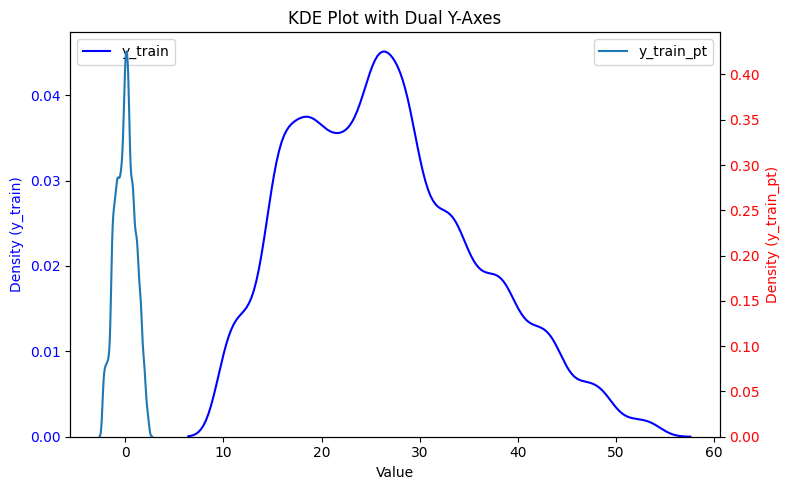

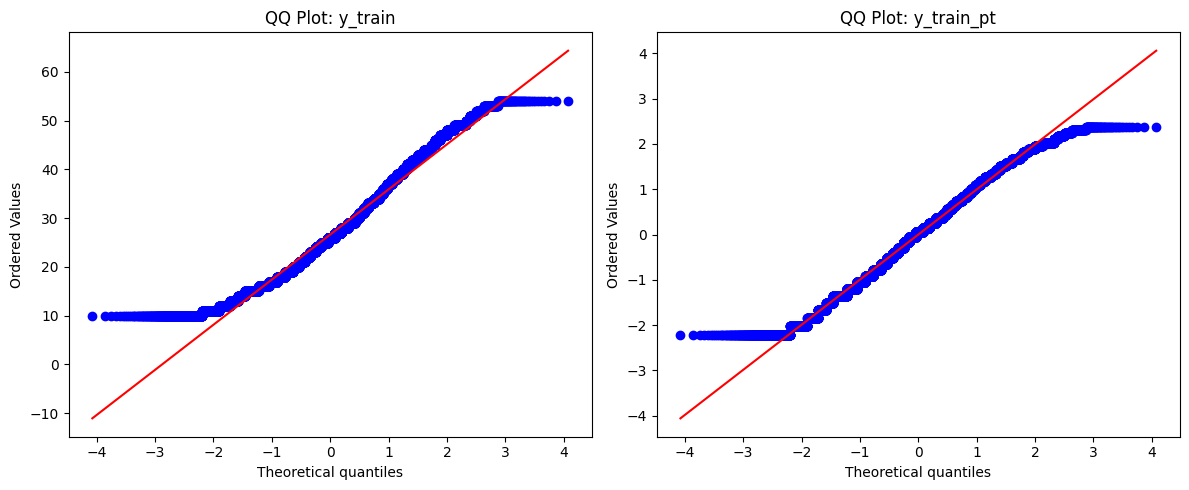

In [50]:
import scipy.stats as stats

fig, ax1 = plt.subplots(figsize = (8, 5))

sns.kdeplot(data = y_train, ax = ax1, color = 'blue', label = 'y_train')
ax1.set_ylabel('Density (y_train)', color = 'blue')
ax1.tick_params(axis = 'y', labelcolor = 'blue')

ax2 = ax1.twinx()
sns.kdeplot(data = y_train_pt, ax = ax2, color = 'red', label = 'y_train_pt')
ax2.set_ylabel('Density (y_train_pt)', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')

ax1.set_xlabel('Value')
ax1.set_title('KDE Plot with Dual Y-Axes')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# --- QQ Plots Side by Side ---
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# QQ plot for y_train
stats.probplot(np.array(y_train).ravel(), dist = "norm", plot = axes[0])
axes[0].set_title('QQ Plot: y_train')

# QQ plot for y_train_pt
stats.probplot(np.array(y_train_pt).ravel(), dist = "norm", plot = axes[1])
axes[1].set_title('QQ Plot: y_train_pt')

plt.tight_layout()
plt.show()


In [56]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather',
                    'type_of_order',
                    'type_of_vehicle',
                    "festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

traffic_order = ["low","medium","high","jam"]
distance_type_order = ["short","medium","long","very_long"]

# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium', 'short', 'long', 'very_long']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


In [58]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


processing_pipeline = Pipeline(steps=[
                                ("preprocess",preprocessor)
                            ])

processing_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scale', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time_minutes',
                                                   'distance']),
                                                 ('nominal_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

In [59]:
X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

In [62]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
from sklearn.metrics import r2_score, mean_absolute_error


In [63]:
def objective(trial):
    with mlflow.start_run(nested=True):
        model_name = trial.suggest_categorical("model",["SVM","RF","KNN","GB","XGB","LGBM"])

        if model_name == "SVM":
            kernel_svm = trial.suggest_categorical("kernel_svm",["linear","poly","rbf"])
            if kernel_svm == "linear":
                c_linear = trial.suggest_float("c_linear",0,10)
                model = SVR(C=c_linear,kernel="linear")

            elif kernel_svm == "poly":
                c_poly = trial.suggest_float("c_poly",0,10)
                degree_poly = trial.suggest_int("degree_poly",1,5)
                model = SVR(C=c_poly,degree=degree_poly,
                            kernel="poly")

            else:
                c_rbf = trial.suggest_float("c_rbf",0,100)
                gamma_rbf = trial.suggest_float("gamma_rbf",0,10)
                model = SVR(C=c_rbf,gamma=gamma_rbf,
                            kernel="rbf")

        elif model_name == "RF":
            n_estimators_rf = trial.suggest_int("n_estimators_rf",10,200)
            max_depth_rf = trial.suggest_int("max_depth_rf",2,20)
            model = RandomForestRegressor(n_estimators=n_estimators_rf,
                                        max_depth=max_depth_rf,
                                        random_state=42,
                                        n_jobs=-1)

        elif model_name == "GB":
            n_estimators_gb = trial.suggest_int("n_estimators_gb",10,200)
            learning_rate_gb = trial.suggest_float("learning_rate_gb",0,1)
            max_depth_gb = trial.suggest_int("max_depth_gb",2,20)
            model = GradientBoostingRegressor(n_estimators=n_estimators_gb,
                                                learning_rate=learning_rate_gb,
                                                max_depth=max_depth_gb,
                                                random_state=42)

        elif model_name == "KNN":
            n_neighbors_knn = trial.suggest_int("n_neighbors_knn",1,25)
            weights_knn = trial.suggest_categorical("weights_knn",["uniform","distance"])
            model = KNeighborsRegressor(n_neighbors=n_neighbors_knn,
                                        weights=weights_knn,n_jobs=-1)

        elif model_name == "XGB":
            n_estimators_xgb = trial.suggest_int("n_estimators_xgb",10,200)
            learning_rate_xgb = trial.suggest_float("learning_rate_xgb",0.1,0.5)
            max_depth_xgb = trial.suggest_int("max_depth_xgb",2,20)
            model = XGBRegressor(n_estimators=n_estimators_xgb,
                                    learning_rate=learning_rate_xgb,
                                    max_depth=max_depth_xgb,
                                    random_state=42,
                                    n_jobs=-1)

        elif model_name == "LGBM":
            n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm",10,200)
            learning_rate_lgbm = trial.suggest_float("learning_rate_lgbm",0.1,0.5)
            max_depth_lgbm = trial.suggest_int("max_depth_lgbm",2,20)
            model = LGBMRegressor(n_estimators=n_estimators_lgbm,
                                    learning_rate=learning_rate_lgbm,
                                    max_depth=max_depth_lgbm,
                                    random_state=42)


        # train the model
        model.fit(X_train_trans,y_train_pt.values.ravel())

        # log model params
        mlflow.log_params(model.get_params())

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)

        # get the actual predictions values
        y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
        y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

        # calculate the error
        error = mean_absolute_error(y_test,y_pred_test_org)

        # log model_name
        mlflow.log_param("model",model_name)

        # log error
        mlflow.log_metric("MAE",error)

        return error


In [64]:
# create optuna study
study = optuna.create_study(direction="minimize",study_name="model_selection")

with mlflow.start_run(run_name="Best Model") as parent:
    # optimize the objective function
    study.optimize(objective,n_trials=30,n_jobs=-1)

    # log the best parameters
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score",study.best_value)

[I 2025-06-07 15:01:28,706] A new study created in memory with name: model_selection
[I 2025-06-07 15:01:31,928] Trial 1 finished with value: 3.6072237491607666 and parameters: {'model': 'XGB', 'n_estimators_xgb': 62, 'learning_rate_xgb': 0.49873023590951204, 'max_depth_xgb': 2}. Best is trial 1 with value: 3.6072237491607666.


🏃 View run bouncy-mule-886 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/e9ce13fc66bf44d09a8a7f5b9e65f928
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:01:33,682] Trial 0 finished with value: 3.099997923913043 and parameters: {'model': 'RF', 'n_estimators_rf': 13, 'max_depth_rf': 15}. Best is trial 0 with value: 3.099997923913043.


🏃 View run clean-wasp-721 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/de559b1c054d4a15b4f01defaa8189bc
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0
🏃 View run exultant-sheep-235 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/8c78f876d3b947d2b7b58c94520f673a
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:01:39,259] Trial 2 finished with value: 3.0824062824249268 and parameters: {'model': 'XGB', 'n_estimators_xgb': 118, 'learning_rate_xgb': 0.3194394723078993, 'max_depth_xgb': 5}. Best is trial 2 with value: 3.0824062824249268.
[I 2025-06-07 15:01:47,801] Trial 3 finished with value: 4.2755217317039635 and parameters: {'model': 'KNN', 'n_neighbors_knn': 18, 'weights_knn': 'uniform'}. Best is trial 2 with value: 3.0824062824249268.


🏃 View run sincere-elk-635 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/3558294de94148108862d4342f4d04a4
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0
🏃 View run useful-hen-304 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/3f932d0538b24a3d952f5d167c45095f
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:01:55,218] Trial 4 finished with value: 3.892610193563687 and parameters: {'model': 'GB', 'n_estimators_gb': 99, 'learning_rate_gb': 0.8311563606881667, 'max_depth_gb': 20}. Best is trial 2 with value: 3.0824062824249268.
[I 2025-06-07 15:02:08,767] Trial 6 finished with value: 4.305362533229066 and parameters: {'model': 'KNN', 'n_neighbors_knn': 5, 'weights_knn': 'distance'}. Best is trial 2 with value: 3.0824062824249268.


🏃 View run righteous-horse-499 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/6b3411a3d5b547ed8be7f7fb1d15f43f
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:02:11,429] Trial 5 finished with value: 3.980165815584172 and parameters: {'model': 'GB', 'n_estimators_gb': 190, 'learning_rate_gb': 0.8852893511083764, 'max_depth_gb': 17}. Best is trial 2 with value: 3.0824062824249268.


🏃 View run nimble-loon-904 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/6b084a0ea09c4cc0ac60b712c899c564
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:02:13,703] Trial 8 finished with value: 3.082159664709031 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 107, 'learning_rate_lgbm': 0.33735328346169996, 'max_depth_lgbm': 7}. Best is trial 8 with value: 3.082159664709031.


🏃 View run wistful-hawk-739 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/ea021d3b18924792aaad54692b1e9b18
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0
🏃 View run chill-elk-376 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/d42bd4060a41473d8bd8349bfd6c642f
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:02:20,358] Trial 7 finished with value: 3.092603971758283 and parameters: {'model': 'RF', 'n_estimators_rf': 53, 'max_depth_rf': 19}. Best is trial 8 with value: 3.082159664709031.
[I 2025-06-07 15:02:28,247] Trial 9 finished with value: 4.304752892869772 and parameters: {'model': 'KNN', 'n_neighbors_knn': 6, 'weights_knn': 'uniform'}. Best is trial 8 with value: 3.082159664709031.


🏃 View run defiant-chimp-253 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/eb2021aae3d94c399a62b92c1769fc25
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0
🏃 View run clean-kite-483 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/298a678a222740f8aaa9e84127285efe
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:02:31,327] Trial 11 finished with value: 3.084065320731969 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 107, 'learning_rate_lgbm': 0.33994792803798457, 'max_depth_lgbm': 6}. Best is trial 8 with value: 3.082159664709031.
[I 2025-06-07 15:02:48,492] Trial 10 finished with value: 4.252744809545899 and parameters: {'model': 'GB', 'n_estimators_gb': 140, 'learning_rate_gb': 0.964009694757004, 'max_depth_gb': 9}. Best is trial 8 with value: 3.082159664709031.


🏃 View run likeable-bee-816 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/b0511e5efaa34aa3a4a130098804a2c4
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:03:07,883] Trial 13 finished with value: 3.1729705333709717 and parameters: {'model': 'XGB', 'n_estimators_xgb': 178, 'learning_rate_xgb': 0.23720832370759065, 'max_depth_xgb': 8}. Best is trial 8 with value: 3.082159664709031.


🏃 View run entertaining-yak-909 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/d64ab1dae2b14438bc2953ff7820fb85
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:08:59,928] Trial 12 finished with value: 4.675446730238823 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 2.6293876468369684}. Best is trial 8 with value: 3.082159664709031.


🏃 View run orderly-fly-186 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/400301f6737348ab9ff6112ae0854bf6
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:09:02,081] Trial 15 finished with value: 3.0256771191954135 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 170, 'learning_rate_lgbm': 0.156638491245091, 'max_depth_lgbm': 16}. Best is trial 15 with value: 3.0256771191954135.


🏃 View run masked-toad-900 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/a09e45fefc764267850aba33b92d8a4d
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:09:05,456] Trial 16 finished with value: 3.0188440116841586 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 197, 'learning_rate_lgbm': 0.10373700778188746, 'max_depth_lgbm': 18}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run useful-turtle-142 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/9a4da5c2f99d4d778d56ca1f140cb57d
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0
🏃 View run serious-bird-446 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/c49253868a024861843d838f9a140191
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:09:10,492] Trial 17 finished with value: 3.022123932612813 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 198, 'learning_rate_lgbm': 0.10426821369104824, 'max_depth_lgbm': 19}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run polite-shark-647 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/5f87eed682c64bd4a29ec20998c3dc0b
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:09:16,498] Trial 18 finished with value: 3.037284877308222 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 199, 'learning_rate_lgbm': 0.1101856727859129, 'max_depth_lgbm': 20}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run dazzling-eel-26 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/71f6f5bc58bf4f33898567426504aa16
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:09:22,516] Trial 19 finished with value: 3.3322622344495962 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 13, 'learning_rate_lgbm': 0.19476231437839728, 'max_depth_lgbm': 16}. Best is trial 16 with value: 3.0188440116841586.
[I 2025-06-07 15:10:10,581] Trial 14 finished with value: 4.675435416467112 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 2.81967976278829}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run unruly-bear-446 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/b8907a0f19bd45b0905fb7fe5bd98c64
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:10:12,763] Trial 21 finished with value: 3.0268744971736696 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 161, 'learning_rate_lgbm': 0.2332067133001004, 'max_depth_lgbm': 19}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run flawless-pug-533 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/38a3e1b8eaf241cb8249edbac4247bb7
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:10:15,919] Trial 22 finished with value: 3.0294476848556013 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 191, 'learning_rate_lgbm': 0.1067645486556251, 'max_depth_lgbm': 14}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run victorious-pig-178 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/bd353e2e290744f598fbdbaed4e42af0
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0
🏃 View run carefree-fly-377 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/1db452b9fda742deb1a8e7328ca948b7
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:10:21,252] Trial 23 finished with value: 3.0383124710141765 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 168, 'learning_rate_lgbm': 0.12919245773066937, 'max_depth_lgbm': 16}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run upbeat-finch-220 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/08dddf290d7e4eb1bf1c70acfe9a7d53
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:10:27,245] Trial 24 finished with value: 3.1164824731221414 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 153, 'learning_rate_lgbm': 0.4421553947355963, 'max_depth_lgbm': 20}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run sneaky-shrew-393 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/06f9d68678794b71894069b8fc719f53
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:10:33,221] Trial 25 finished with value: 3.0328539713304297 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 197, 'learning_rate_lgbm': 0.1901956855134802, 'max_depth_lgbm': 12}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run clumsy-kite-857 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/884de43ea6214f1f87c1ce01bc552384
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:10:39,226] Trial 26 finished with value: 3.0538894924193527 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 136, 'learning_rate_lgbm': 0.16668941773489332, 'max_depth_lgbm': 17}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run handsome-asp-368 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/f95d817a3de84dc893338ab0518e530e
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:10:45,218] Trial 27 finished with value: 3.084773081173449 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 33, 'learning_rate_lgbm': 0.2590942904906283, 'max_depth_lgbm': 17}. Best is trial 16 with value: 3.0188440116841586.
[I 2025-06-07 15:14:09,856] Trial 28 finished with value: 4.674359024439116 and parameters: {'model': 'SVM', 'kernel_svm': 'poly', 'c_poly': 1.007661296415101, 'degree_poly': 1}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run calm-shrike-362 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/52b79d1ecfb940fe886d1268f17e38d9
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:14:18,491] Trial 29 finished with value: 5.863904829735169 and parameters: {'model': 'RF', 'n_estimators_rf': 200, 'max_depth_rf': 2}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run redolent-elk-973 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/dac1ee3ae1224fa2a29cbfdbf5644b86
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


[I 2025-06-07 15:19:49,377] Trial 20 finished with value: 5.9850367246861245 and parameters: {'model': 'SVM', 'kernel_svm': 'rbf', 'c_rbf': 94.05624779716419, 'gamma_rbf': 3.244134568614899}. Best is trial 16 with value: 3.0188440116841586.


🏃 View run skillful-moose-166 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/76c32c32b16641608da60a481834fd46
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0
🏃 View run Best Model at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/a34a809a96c14a01a4d534800e1f5833
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


In [66]:
study.best_value , study.best_params

(3.0188440116841586,
 {'model': 'LGBM',
  'n_estimators_lgbm': 197,
  'learning_rate_lgbm': 0.10373700778188746,
  'max_depth_lgbm': 18})

In [71]:
lgbm_params = {  'n_estimators': 197,
  'learning_rate': 0.10373700778188746,
  'max_depth': 18}

In [72]:
lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(X_train_trans,y_train_pt.values.ravel())

# get the predictions
y_pred_train = lgbm.predict(X_train_trans)
y_pred_test = lgbm.predict(X_test_trans)

# get the actual predictions values
y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))


from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
The train error is 2.83 minutes
The test error is 3.02 minutes
The train r2 score is 0.86
The test r2 score is 0.84


In [76]:
# model frequency
opt_df = pd.DataFrame(
    {
        "model" : study.trials_dataframe()['params_model'].value_counts().index,
        "freq" : study.trials_dataframe()['params_model'].value_counts().values,
        "MAE" : study.trials_dataframe().groupby("params_model")['value'].mean().sort_values().values

        }

)
opt_df

,model,freq,MAE
0,LGBM,14,3.070361
1,SVM,4,3.287534
2,XGB,3,4.018836
3,RF,3,4.041840
4,GB,3,4.295212
5,KNN,3,5.002569


#### Logging models error table

In [83]:
opt_df.to_csv("model_frequency_summary.csv", index=False)
with mlflow.start_run():

    # Log the DataFrame CSV as an artifact
    mlflow.log_artifact("/content/model_frequency_summary.csv", artifact_path="tables")

🏃 View run defiant-steed-49 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0/runs/de4c55cdcd7f41dd9f3902e6f4949d69
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/0


### Cross Validation

In [85]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor=lgbm,
                                    transformer=pt)


from sklearn.model_selection import cross_val_score

scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         scoring="neg_mean_absolute_error",
                         cv=5,n_jobs=-1)

scores, - scores.mean()

(array([-3.07537309, -3.04923174, -3.06300195, -3.05880512, -3.05474404]),
 np.float64(3.0602311887321374))

### Further Hyper Tuning

In [88]:
mlflow.set_experiment("Exp 2 - LGBM HP Tuning")

2025/06/07 16:20:05 INFO mlflow.tracking.fluent: Experiment with name 'Exp 2 - LGBM HP Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/b04dc82728fe469fbf6f4c10e7922cea', creation_time=1749313205951, experiment_id='1', last_update_time=1749313205951, lifecycle_stage='active', name='Exp 2 - LGBM HP Tuning', tags={}>

In [89]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators",10,200),
            "max_depth": trial.suggest_int("max_depth",1,40),
            "learning_rate": trial.suggest_float("learning_rate",0.1,0.8),
            "subsample": trial.suggest_float("subsample",0.5,1),
            "min_child_weight": trial.suggest_int("min_child_weight",5,20),
            "min_split_gain": trial.suggest_float("min_split_gain",0,10),
            "reg_lambda": trial.suggest_float("reg_lambda",0,100),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model parameters
        mlflow.log_params(params)

        xgb_reg = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=xgb_reg,transformer=pt)

        # train the model
        model.fit(X_train_trans,y_train)

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)


        # perform cross validation
        cv_score = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="neg_mean_absolute_error",
                                n_jobs=-1)

        # mean score
        mean_score = -(cv_score.mean())
        # log avg cross val error
        mlflow.log_metric("cross_val_error",mean_score)

        return mean_score

In [90]:
# create optuna study
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # optimize the objective function
    study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

    # log the best parameters
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score",study.best_value)

    # train the model on best parameters
    best_lgbm = LGBMRegressor(**study.best_params)

    best_lgbm.fit(X_train_trans,y_train_pt.values.ravel())

    # get the predictions
    y_pred_train = best_lgbm.predict(X_train_trans)
    y_pred_test = best_lgbm.predict(X_test_trans)

    # get the actual predictions values
    y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))


    # perform cross validation
    model = TransformedTargetRegressor(regressor=best_lgbm,
                                        transformer=pt)


    scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         scoring="neg_mean_absolute_error",
                         cv=5,n_jobs=-1)

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",- scores.mean())

    # log the best model
    mlflow.sklearn.log_model(best_lgbm,artifact_path="model")

[I 2025-06-07 16:20:10,464] A new study created in memory with name: no-name-a44f8b0f-a154-4bc6-8445-a2a563a6de4f


  0%|          | 0/50 [00:00<?, ?it/s]

🏃 View run rumbling-ram-82 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/1/runs/07bd6264832c440694aadaf29864af34
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/1
[I 2025-06-07 16:20:36,278] Trial 0 finished with value: 3.749984757790847 and parameters: {'n_estimators': 24, 'max_depth': 10, 'learning_rate': 0.32014712305439774, 'subsample': 0.7689164541203828, 'min_child_weight': 7, 'min_split_gain': 8.84880358194325, 'reg_lambda': 73.89827847061098}. Best is trial 0 with value: 3.749984757790847.
🏃 View run puzzled-conch-146 at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/1/runs/7ff12332f2c94a1180ad957cdce4d562
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/1
[I 2025-06-07 16:20:36,498] Trial 1 finished with value: 3.711216978988422 and parameters: {'n_estimators': 186, 'max_depth': 24, 'learning_rate': 0

2025/06/07 16:26:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run best_model at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/1/runs/edb20fa3242d425ca37f2fa608c0bd22
🧪 View experiment at: https://dagshub.com/AbdurRahman22224/swiggy-del-time-predn.mlflow/#/experiments/1


In [91]:
study.best_params, study.best_value

({'n_estimators': 102,
  'max_depth': 27,
  'learning_rate': 0.31372375074403747,
  'subsample': 0.550242839101596,
  'min_child_weight': 6,
  'min_split_gain': 0.08875255169057228,
  'reg_lambda': 41.83832552457232},
 3.1694261815418896)